In [14]:
import warnings;warnings.filterwarnings('ignore')

import numpy as np
from glob import glob
import random;random.seed(17)
import cv2 
from tqdm import tqdm
from PIL import ImageFile;ImageFile.LOAD_TRUNCATED_IMAGES=True                 

import matplotlib.pyplot as plt                        
%matplotlib inline                               

from sklearn.datasets import load_files       

from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dropout,Flatten,Dense,BatchNormalization,Activation
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  
from extract_bottleneck_features import *

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data=load_files(path)
    dog_files=np.array(data['filenames'])
    dog_targets=np_utils.to_categorical(np.array(data['target']),133)
    return dog_files,dog_targets

In [3]:
# load train, test, and validation datasets
train_files,train_targets=load_dataset('dogImages/train')
valid_files,valid_targets=load_dataset('dogImages/valid')
test_files,test_targets=load_dataset('dogImages/test')

# print statistics about the dataset
print('There are {} total dog images.'.format(len(np.hstack([train_files,valid_files,test_files]))))
print('There are {} training dog images.'.format(len(train_files)))
print('There are {} validation dog images.'.format(len(valid_files)))
print('There are {} test dog images.'.format(len(test_files)))

There are 8351 total dog images.
There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [4]:
# load list of dog names
dog_names=[item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

print('There are {} total dog categories.'.format(len(dog_names)))

There are 133 total dog categories.


In [5]:
# load filenames in shuffled human dataset
human_files=np.array(glob('lfw/*/*'))
random.shuffle(human_files)

# print statistics about the dataset
print('There are {} human images.'.format(len(human_files)))

There are 13233 human images.


In [6]:
# extract first 100 images
human_files_short=human_files[:100]
dog_files_short=train_files[:100]

### Use Haar Cascade Classifier to Detect Human Faces

In [7]:
# extract pre-trained face detector
face_cascade=cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml') 

In [8]:
# detect faces with pre-trained face detector
img=cv2.imread(human_files[1]) # load color (BGR) image
img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # convert BGR image to grayscale
faces=face_cascade.detectMultiScale(img_gray) # find faces in image

# print number of faces detected in the image
print('Number of faces detected:',len(faces))

Number of faces detected: 1


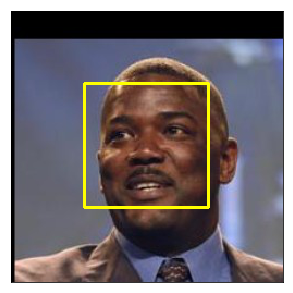

In [9]:
# get bounding box for each detected face
for (x,y,w,h) in faces:    
    cv2.rectangle(img,(x,y),(x+w,y+h),color=(0,255,255),thickness=2) # add bounding box to color image    

# display the image, along with bounding box
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111,xticks=[],yticks=[])
img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # convert BGR image to RGB for plotting
ax.imshow(img_rgb); 

In [10]:
# returns 'True' if face is detected in image stored at 'img_path'
def face_detector(img_path):
    img=cv2.imread(img_path)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(gray)
    return len(faces)>0

In [10]:
# test human face detector with the first 100 images in 'human_files' and 'dog_files'
human_check_list=[face_detector(path) for path in human_files_short] # check human detection accuracy
dog_check_list=[face_detector(path) for path in dog_files_short] # check dog non-detection accuracy

print('Human face detection accuracy: {}%'.format(sum(human_check_list)))
print('Dog face non-detection accuracy: {}%'.format(100-sum(dog_check_list)))

Human face detection accuracy: 98%
Dog face non-detection accuracy: 89%


### Use ResNet50 to Detect Dogs

In [11]:
# define ResNet50 model
ResNet50_model=ResNet50(weights='imagenet')

In [12]:
# define function that convert image to array given image path
def path_to_tensor(img_path):
    img=image.load_img(img_path,target_size=(224,224)) # loads RGB image as PIL.Image.Image type
    x=image.img_to_array(img) # convert PIL.Image.Image type to 3D tensor with shape (224,224,3)
    return np.expand_dims(x,axis=0) # convert 3D tensor to 4D tensor with shape (1,224,224,3) and return 4D tensor

# define function that stacks image arrays
def paths_to_tensor(img_paths):
    list_of_tensors=[path_to_tensor(img_path) for img_path in tqdm(img_paths)] 
    return np.vstack(list_of_tensors)

# define function that returns index of Resnet50 prediction
def ResNet50_predict_labels(img_path):
    img=preprocess_input(path_to_tensor(img_path)) # returns prediction vector for image located at 'img_path'
    return np.argmax(ResNet50_model.predict(img))

# returns "True" if a dog is detected in the image stored at 'img_path'
def dog_detector(img_path):
    prediction=ResNet50_predict_labels(img_path)
    return ((prediction<=268)&(prediction>=151)) 

In [24]:
# test the performance of the 'dog_detector' function on the images in 'human_files_short' and 'dog_files_short'
human_check_list=[dog_detector(path) for path in human_files_short] # check human non-detection accuracy
dog_check_list=[dog_detector(path) for path in dog_files_short] # check dog detection accuracy

print('Human face non-detection accuracy: {}%'.format(100-sum(human_check_list)))
print('Dog face detection accuracy: {}%'.format(sum(dog_check_list)))

Human face non-detection accuracy: 97%
Dog face detection accuracy: 100%


### Create a CNN to Classify Dog Breeds (from Scratch)

In [18]:
# pre-process the data for Keras
train_tensors=paths_to_tensor(train_files).astype('float32')/255
valid_tensors=paths_to_tensor(valid_files).astype('float32')/255
test_tensors=paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:14<00:00, 57.83it/s]


In [19]:
# define model architecture
model=Sequential()

model.add(Conv2D(filters=16,kernel_size=(2,2),padding='same',input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(133,activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
activation_53 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_54 (Activation)   (None, 112, 112, 32)      0         
__________

In [20]:
# compile the model
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
# train the model
checkpointer=ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',verbose=1,save_best_only=True)
model.fit(train_tensors,train_targets,validation_data=(valid_tensors,valid_targets),epochs=5,batch_size=20,
          callbacks=[checkpointer],verbose=1);

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 523s - loss: 4.8412 - acc: 0.0207 - val_loss: 4.8734 - val_acc: 0.0132
Epoch 2/5
6680/6680 [==============================] - 510s - loss: 4.6751 - acc: 0.0401 - val_loss: 4.7321 - val_acc: 0.0263
Epoch 3/5
6680/6680 [==============================] - 511s - loss: 4.6138 - acc: 0.0472 - val_loss: 4.6819 - val_acc: 0.0347
Epoch 4/5
6680/6680 [==============================] - 562s - loss: 4.5501 - acc: 0.0484 - val_loss: 4.6821 - val_acc: 0.0311
Epoch 5/5
6680/6680 [==============================] - 508s - loss: 4.4911 - acc: 0.0531 - val_loss: 4.6206 - val_acc: 0.0359


In [22]:
# load model weights
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [23]:
# report test accuracy of test set
dog_breed_predictions=[np.argmax(model.predict(np.expand_dims(tensor,axis=0))) 
                       for tensor in test_tensors] # get index of predicted dog breed for each image in test set
test_accuracy=100*np.sum(np.array(dog_breed_predictions)
                         ==np.argmax(test_targets,axis=1))/len(dog_breed_predictions) # compute test accuracy

print('Test accuracy: {0:.4f}%'.format(test_accuracy))

Test accuracy: 3.2297%


### Use a CNN to Classify Dog Breeds (Using Transfer Learning)

In [26]:
# obtain bottleneck features from another pre-trained CNN
def features_extractor(model_name): 
    bottleneck_features=np.load('bottleneck_features/Dog'+model_name+'Data.npz')
    train_model=bottleneck_features['train']
    valid_model=bottleneck_features['valid']
    test_model=bottleneck_features['test']
    return train_model,valid_model,test_model
    
features_extractor('VGG16')
features_extractor('VGG19')
features_extractor('Resnet50')
features_extractor('InceptionV3')
features_extractor('Xception');

In [27]:
# define model architecture.
def model_builder(model_name):
    model=Sequential()
    model.add(GlobalAveragePooling2D(input_shape=features_extractor(model_name)[0].shape[1:]))
    model.add(Dense(133,activation='softmax')) 
    return model,model.summary()

VGG16_model=model_builder('VGG16')[0]
VGG19_model=model_builder('VGG19')[0]
Resnet50_model=model_builder('Resnet50')[0]
Inception_model=model_builder('InceptionV3')[0]
Xception_model=model_builder('Xception')[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________
________________________________________________________

In [28]:
# compile the model.
def model_compiler(model):
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    return model

VGG16_model=model_compiler(VGG16_model)
VGG19_model=model_compiler(VGG19_model)
Resnet50_model=model_compiler(Resnet50_model)
Inception_model=model_compiler(Inception_model)
Xception_model=model_compiler(Xception_model)

In [33]:
# train the model
def model_trainer(model_name,model):
    checkpointer=ModelCheckpoint(filepath='saved_models/weights.best.'+model_name+'.hdf5',verbose=0,
                                 save_best_only=True)
    model.fit(features_extractor(model_name)[0],train_targets, 
              validation_data=(features_extractor(model_name)[1],valid_targets),
              epochs=20,batch_size=20,callbacks=[checkpointer],verbose=1)
    return model

In [34]:
VGG16_model=model_trainer('VGG16',VGG16_model)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.2861 - acc: 0.1337 - val_loss: 10.8178 - val_acc: 0.2084

In [39]:
VGG19_model=model_trainer('VGG19',VGG19_model)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 11.2685 - acc: 0.1461 - val_loss: 9.4361 - val_acc: 0.2539

In [40]:
Resnet50_model=model_trainer('Resnet50',Resnet50_model)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 1.6279 - acc: 0.5939 - val_loss: 0.8007 - val_acc: 0.7653

In [10]:
Inception_model=model_trainer('InceptionV3',Inception_model)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s - loss: 1.1424 - acc: 0.7076 - val_loss: 0.6372 - val_acc: 0.8108

In [11]:
Xception_model=model_trainer('Xception',Xception_model)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s - loss: 1.0586 - acc: 0.7371 - val_loss: 0.5171 - val_acc: 0.8216

In [29]:
# load the model weights with the best validation loss
def weight_selector(model_name,model):
    model.load_weights('saved_models/weights.best.'+model_name+'.hdf5')
    return model

VGG16_model=weight_selector('VGG16',VGG16_model)
VGG19_model=weight_selector('VGG19',VGG19_model)
Resnet50_model=weight_selector('Resnet50',Resnet50_model)
Inception_model=weight_selector('InceptionV3',Inception_model)
Xception_model=weight_selector('Xception',Xception_model)

In [30]:
# calculate classification accuracy on the test dataset.
def model_predictor(model_name,model):
    model_predictions=[np.argmax(model.predict(np.expand_dims(feature,axis=0))) 
                       for feature in features_extractor(model_name)[2]]
    test_accuracy=100*np.sum(np.array(model_predictions)==np.argmax(test_targets,axis=1))/len(model_predictions)
    print(model_name+' test accuracy: {0:.4f}%'.format(test_accuracy))
    
model_predictor('VGG16',VGG16_model)
model_predictor('VGG19',VGG19_model)
model_predictor('Resnet50',Resnet50_model)
model_predictor('InceptionV3',Inception_model)
model_predictor('Xception',Xception_model)

VGG16 test accuracy: 38.5167%
VGG19 test accuracy: 51.6746%
Resnet50 test accuracy: 82.2967%
InceptionV3 test accuracy: 77.3923%
Xception test accuracy: 85.1675%


In [31]:
# define a function that takes a path to an image as input and returns the dog breed that is predicted by the model
def predict_breed(img_path,extract_model,model):
    bottleneck_feature=extract_model(path_to_tensor(img_path)) # extract bottleneck features
    predicted_vector=model.predict(bottleneck_feature) # obtain predicted vector
    return dog_names[np.argmax(predicted_vector)]

pred_breed_VGG16=predict_breed(test_files[100],extract_VGG16,VGG16_model)
pred_breed_VGG19=predict_breed(test_files[100],extract_VGG19,VGG19_model)
pred_breed_Resnet50=predict_breed(test_files[100],extract_Resnet50,Resnet50_model)
pred_breed_Inception=predict_breed(test_files[100],extract_InceptionV3,Inception_model)
pred_breed_Xception=predict_breed(test_files[100],extract_Xception,Xception_model)

print('VGG16:',pred_breed_VGG16)
print('VGG19:',pred_breed_VGG19)
print('Resnet50:',pred_breed_Resnet50)
print('Inception:',pred_breed_Inception)
print('Xception:',pred_breed_Xception)

VGG16: American_staffordshire_terrier
VGG19: Bulldog
Resnet50: American_staffordshire_terrier
Inception: American_staffordshire_terrier
Xception: American_staffordshire_terrier


### Write a Dog App

In [24]:
# define a function that accepts an image path and determines whether the image contains a human, dog, or neither
def dog_app(image_path):
    if dog_detector(image_path):
        print('You are a '+predict_breed(image_path,extract_Xception,Xception_model)+'. AM I RIGHT!')
    elif face_detector(image_path):
        print('You can pass as a '+predict_breed(image_path,extract_Xception,Xception_model)+'...')
    else:
        print('Make no mistake. We are only good with dogs so far...')
    img=cv2.imread(image_path)
    cv_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig=plt.figure(figsize=(5,5))
    ax=fig.add_subplot(111,xticks=[],yticks=[])
    ax.imshow(cv_rgb) # display loaded image
    plt.show()

There are 6 test images.

Make no mistake. We are only good with dogs so far...


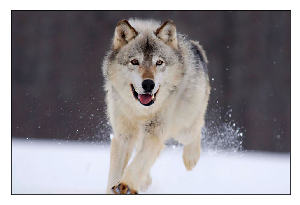

You can pass as a Chinese_crested...


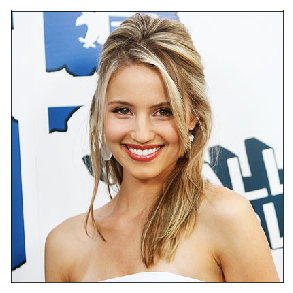

Make no mistake. We are only good with dogs so far...


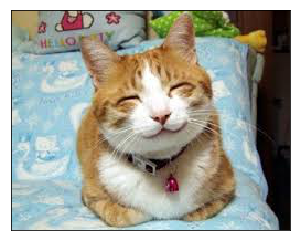

You are a Pomeranian. AM I RIGHT!


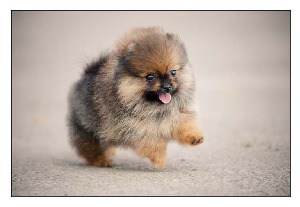

You can pass as a Japanese_chin...


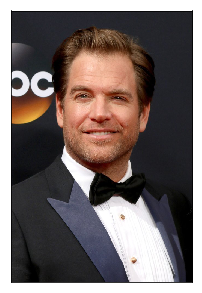

You are a Pomeranian. AM I RIGHT!


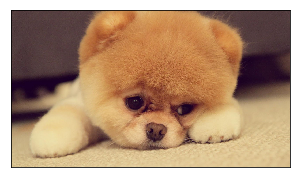

In [32]:
# test dog app
test_file_paths=np.array(glob('dogImages/test_app/*'))
random.shuffle(test_file_paths)
print('There are {} test images.\n'.format(len(test_file_paths)))

for path in test_file_paths:
    dog_app(path)